# Uber market demand prediction using ARIMA

Market demand plays a crucial part in the marketing strategy of any company. Forecasting such demand becomes crucial when the market is filled with competition, and a small mismatch in supply and demand can lead to a customer switching to another service provider.

In this notebook we look at a classical algorithm(ARIMA) which can be used to predict the demand for user trips in the upcoming week for a particular location. Particularly, we will be utilizing Uber's 2014 user trips data of New York city, to accomplish the same.

The dataset can be found on kaggle.com(https://www.kaggle.com/fivethirtyeight/uber-pickups-in-new-york-city)

In [4]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

First we upload our data-set into a single data-frame:

In [5]:
#Preparing the uber 2014 main dataset
def prepare_2014_df():
    
    #Loading datasets
    uber_2014_apr=pd.read_csv('uber-raw-data-apr14.csv',header=0)
    uber_2014_may=pd.read_csv('uber-raw-data-may14.csv',header=0)
    uber_2014_jun=pd.read_csv('uber-raw-data-jun14.csv',header=0)
    uber_2014_jul=pd.read_csv('uber-raw-data-jul14.csv',header=0)
    uber_2014_aug=pd.read_csv('uber-raw-data-aug14.csv',header=0)
    uber_2014_sep=pd.read_csv('uber-raw-data-sep14.csv',header=0)
    
    #Merging
    df = uber_2014_apr.append([uber_2014_may,uber_2014_jun,uber_2014_jul,uber_2014_aug,uber_2014_sep], ignore_index=True)
    
    #returning merged dataframe
    return df

#Uber 2014 dataset
uber_2014_master = prepare_2014_df()
uber_2014_master.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


Next, we prepare the data-frame so that it is in a time-series format, which can then be utilized for modelling.
Since we are only looking at a basic time-series forecast model, we will only be utilizing the Date/Time column for now.

I plan to predict the demand at a day level and hence we will be resampling the data at a day level. However deping on the need, we can sample the data at different levels(Hour,Month,Year etc.)

In [6]:
# Feature Engineering
def create_day_series(df):
    
    # Grouping by Date/Time to calculate number of trips
    day_df = pd.Series(df.groupby(['Date/Time']).size())
    # setting Date/Time as index
    day_df.index = pd.DatetimeIndex(day_df.index)
    # Resampling to daily trips
    day_df = day_df.resample('1D').apply(np.sum)
    
    return day_df

day_df_2014 = create_day_series(uber_2014_master)
day_df_2014.head()

Date/Time
2014-04-01    14546
2014-04-02    17474
2014-04-03    20701
2014-04-04    26714
2014-04-05    19521
Freq: D, dtype: int64

Now that we have the time-series data-frame ready, we can look into some initial visualizations of the data to decide our parameters for the ARIMA model

p-value: 0.84589808249


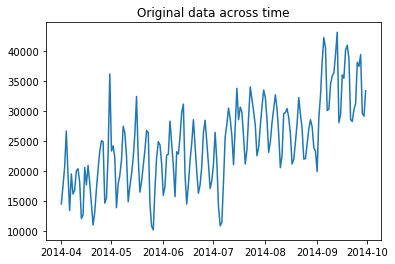

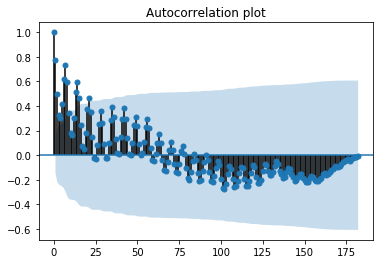

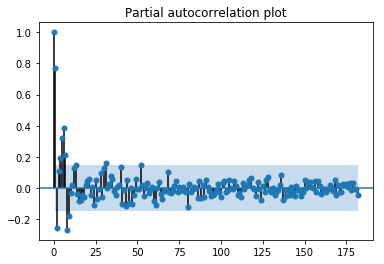

In [7]:
#Checking trend and autocorrelation
def initial_plots(time_series):

    #Original timeseries plot
    plt.figure(1)
    plt.plot(time_series)
    plt.title('Original data across time')
    plt.figure(2)
    plot_acf(time_series)
    plt.title('Autocorrelation plot')
    plot_pacf(time_series)
    plt.title('Partial autocorrelation plot')
    
    plt.show()
    
    

#Augmented Dickey-Fuller test for stationarity
#checking p-value
print('p-value: {}'.format(adfuller(day_df_2014)[1]))

#plotting
initial_plots(day_df_2014)


Looking at the ADF test we see that clearly the time-series is not stationary(p-value>0.05 i.e for a confidence level of 95%), hence differencing is required.

Before we even analyse the ACF and PACF plots we need to difference and test for stationarity

In [8]:
#storing differenced series
diff_series = day_df_2014.diff(periods=1)

#Augmented Dickey-Fuller test for stationarity
#checking p-value
print('p-value: {}'.format(adfuller(diff_series.dropna())[1]))

p-value: 1.51636411774e-08


Looks like the series is stationary now (as p-value < 0.05, we can assume stationarity with a confidence level of 95%, even higher actually). So a differencing of 1 should be perfect!

Now lets look at the ACF and PACF plots:

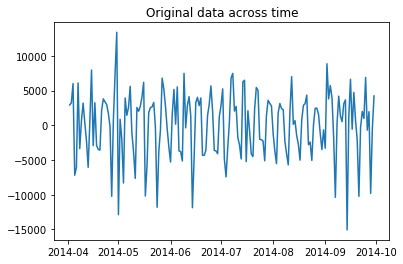

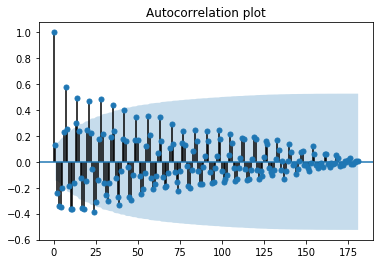

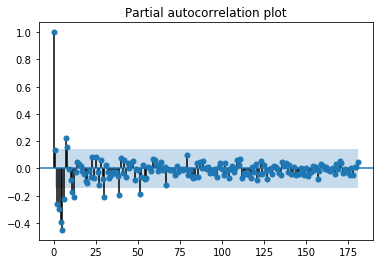

In [9]:
initial_plots(diff_series.dropna())

The plots show us that this is a mixture of both AR and MA process. I will not go further into deciding the generation process. To figure out the process we will have to delve into EACF plots which is beyond our scope for this example.

For best results an automatic ARIMA estimate the ARIMA() function from statsmodels library can be used. However, we will fit simple models on the data set and try to figure out a good fit manually(again just for the sake of this example).

AIC = 3480.53
BIC = 3509.37


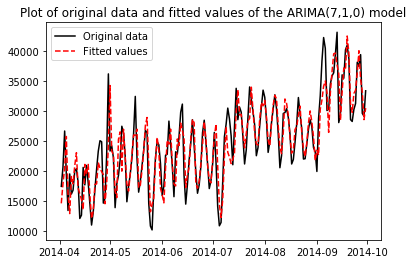

In [10]:
#fitting ARIMA model on dataset
def ARIMA_call(time_series,p,d,q):    
    
    #fitting the model
    ARIMA_model = ARIMA(time_series.astype(float), order=(p,d,q))
    ARIMA_model_fit = ARIMA_model.fit(disp=0)
    print ('AIC = {}'.format(np.round(ARIMA_model_fit.aic,2)))
    print ('BIC = {}'.format(np.round(ARIMA_model_fit.bic,2)))
    fitted_values = ARIMA_model_fit.predict(1,len(time_series)-1,typ='levels') #Index starts at 1 as differencing is in effect
    
    #Plotting
    plt.figure(3)
    plt.title('Plot of original data and fitted values of the ARIMA({},{},{}) model'.format(p,d,q))
    plt.plot(time_series[1:],'k-',label='Original data') #Plotting from index of 1 as differencing is in effect
    plt.plot(fitted_values,'r--',label='Fitted values')
    plt.legend()
    plt.show()
    
    #returning the fitted model and values
    return ARIMA_model_fit,fitted_values

fitted_model,fitted_values = ARIMA_call(day_df_2014,7,1,0)

I have fit an ARIMA(7,1,0) model on this dataset.

The model was chosen after iterating through different AR and MA values(represented by p,d,q respectively in the ARIMA_call). The 7,1,0 parameters gave low AIC and BIC scores for this time-series, which is a sign of good fit on the dataset. This will do for the sake of this example.

Note that for predictions RMSE(or any other error term like MAE or MAPE) values matter, and should be the deciding factor for the best model to predict future values. I will not delve into splitting the datset into the testing and training and iterating for different p,d,q values to select the best model for predicting future values.

I will just show how the fitted model can be used to get predictions:

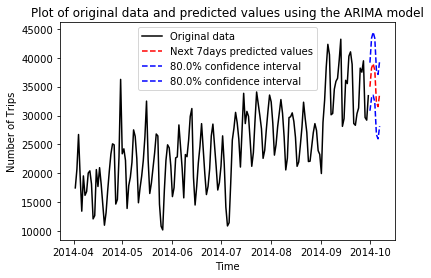

In [11]:
#Predicting values using the fitted model
def predict(df,fitted_model,n_days,conf):
    
    #Predicting
    values = pd.DataFrame(fitted_model.forecast(steps=n_days,alpha=(1-conf))[0],columns=['Prediction'])
    values.index = pd.date_range(df.index.max()+1,periods=n_days)
    conf_int = pd.DataFrame(fitted_model.forecast(steps=n_days,alpha=(1-conf))[2],columns=['Conf_int_lower_lim','Conf_int_upper_lim'])
    conf_int.index = pd.date_range(df.index.max()+1,periods=n_days)
    ARIMA_prediction = pd.merge(values,conf_int,left_index=True,right_index=True)
    
    #Plotting
    plt.figure(4)
    plt.title('Plot of original data and predicted values using the ARIMA model')
    plt.xlabel('Time')
    plt.ylabel('Number of Trips')
    plt.plot(df[1:],'k-', label='Original data')
    plt.plot(values,'r--', label='Next {}days predicted values'.format(n_days))
    plt.plot(conf_int,'b--', label='{}% confidence interval'.format(round(conf*100)))
    plt.legend()
    plt.show()
    
    #Returning predicitons
    return ARIMA_prediction

#Predicting the values and builing an 80% confidence interval
prediction = predict(day_df_2014,fitted_model,7,0.80)

As with any prediction, there is uncertainity associated with the result. However, the 80% confidence interval across the predicted values shows us that we are 80% confident that we have found an interval which contains the actual predicted values of the time-series.

Thus using this simple classical ARIMA model we can utilize the forecasted data to plan and alter our marketing strategy for the upcoming week(or any timeframe upon which predictions are to be made) in any location.

In this example, I have just used the complete dataset to forecast the demand, however we need not restrict ourselves to this level. We can split the data-set based on location and obtain forecasts for different pick-up zones in NYC(which would add even more value towards our predictions).